## Лабораторная работа 2. Мяков Тимофей, Шустров Дмитрий

In [29]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns

import networkx as nx
import pandas as pd
import numpy as np

from sklearn.metrics import (
        pairwise_distances,     
        davies_bouldin_score, 
        calinski_harabasz_score, 
        rand_score, 
        silhouette_score
    )

from sklearn.metrics.cluster import (
    adjusted_mutual_info_score, 
    pair_confusion_matrix, 
    contingency_matrix
)

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering

In [30]:
RANDOM_SEED = 154

ROOT_PATH = Path()

X_DATA_PATH =  ROOT_PATH / 'data/X_4_5.xlsx'
Y_DATA_PATH = ROOT_PATH / 'data/Y_4_5.xlsx'

In [31]:
x_data = pd.read_excel(X_DATA_PATH, header=None)
y_data = pd.read_excel(Y_DATA_PATH, header=None)

# Подготовка данных

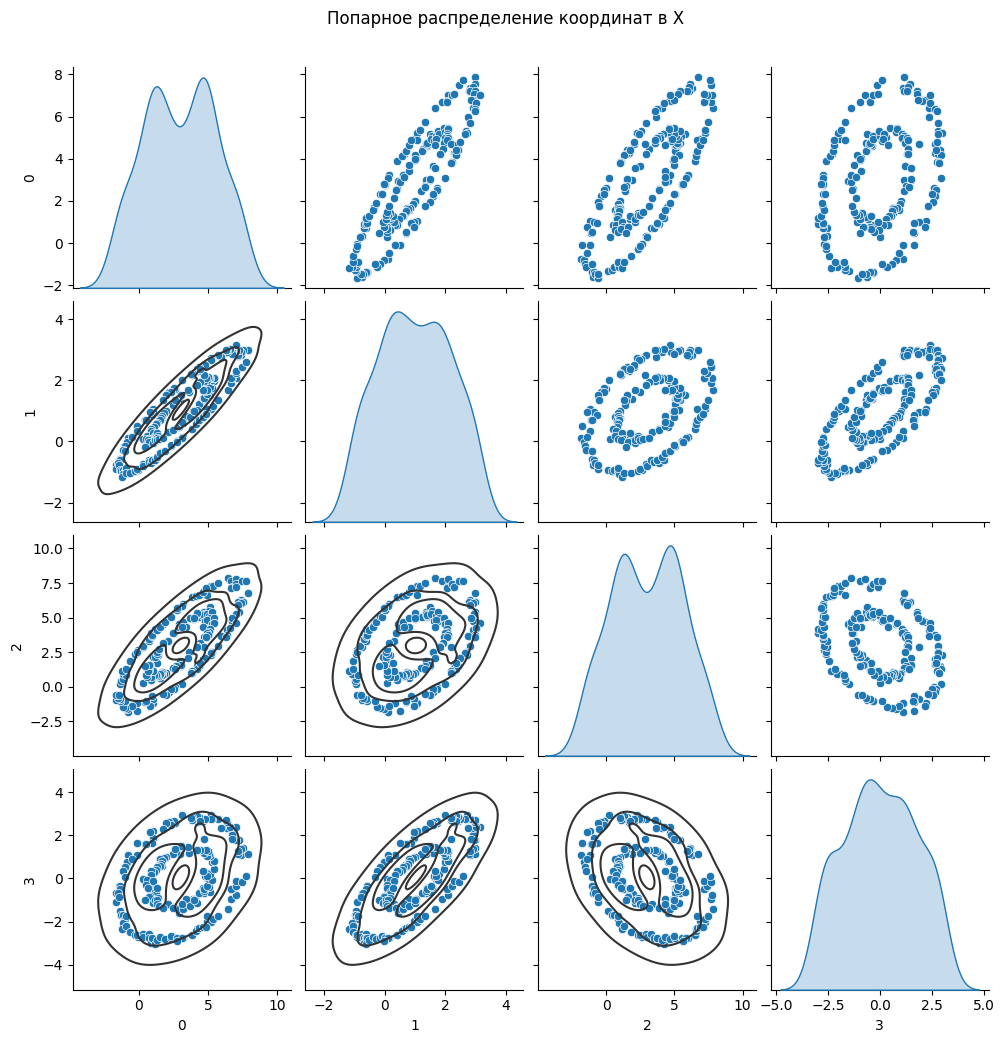

In [32]:
g = sns.pairplot(x_data, diag_kind='kde')
g.map_lower(sns.kdeplot, levels=4, color='.2')
g.figure.suptitle('Попарное распределение координат в X', y=1.04);

В данных X наблюдается два кластера

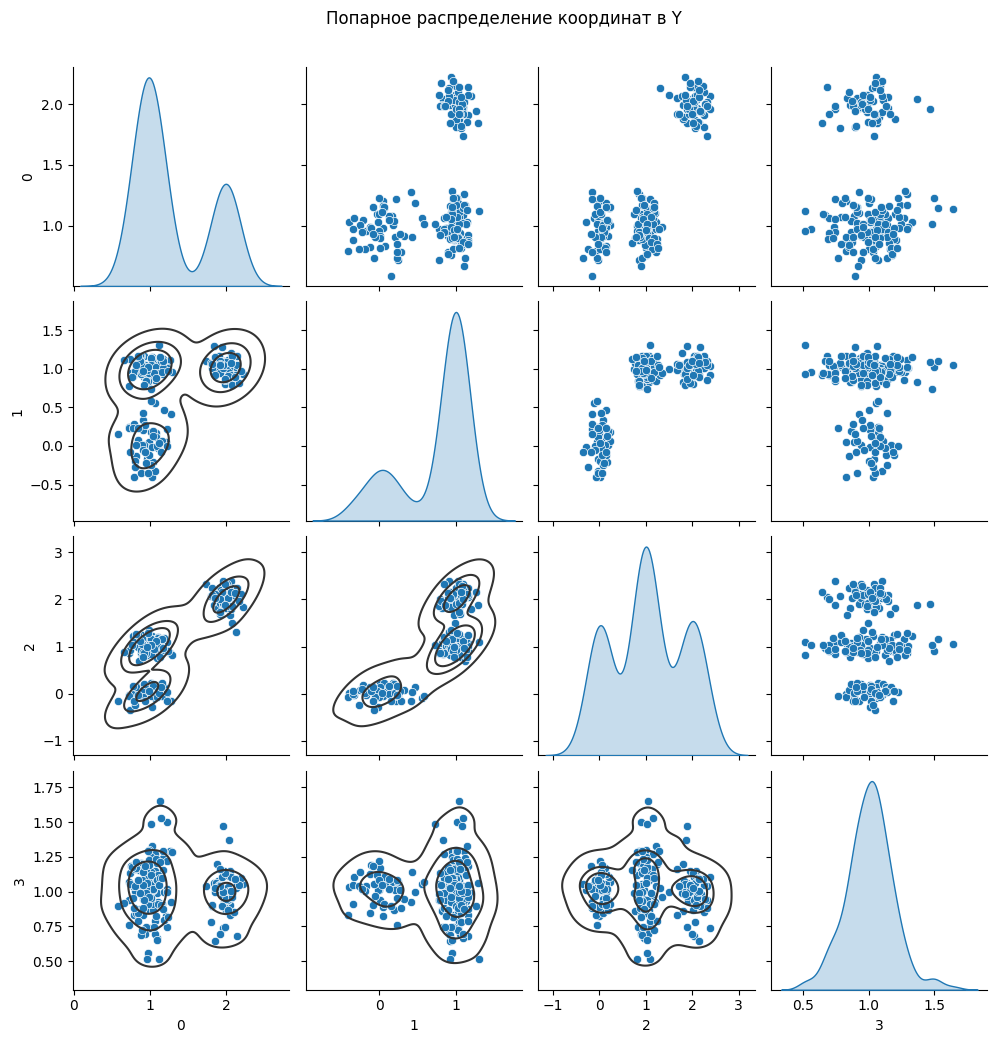

In [33]:
g = sns.pairplot(y_data, diag_kind='kde')
g.map_lower(sns.kdeplot, levels=4, color='.2')
g.figure.suptitle('Попарное распределение координат в Y', y=1.04);

В данных Y наблюдается три кластера

## Выводы:

In [34]:
def get_dst_sim(data, metric):
    distance = pairwise_distances(data, metric=metric)
    np.fill_diagonal(distance, 0)

    sigma = 0.3
    similarity = np.exp(-distance**2 / (2 * sigma**2))
    np.fill_diagonal(similarity, 0)
    
    return distance, similarity

Как метрики расстояния, мы выбрали Euclidean, Manhattan расстояния, так как наиболее популярным и распространенным и реализованы в библиотеке scikit-learn. Выше написана функция, вычисляющая матрицу расстояний и матрицу близостей по заданной метрике. Для перехода к матьрице близости используется Гауссовское ядро.

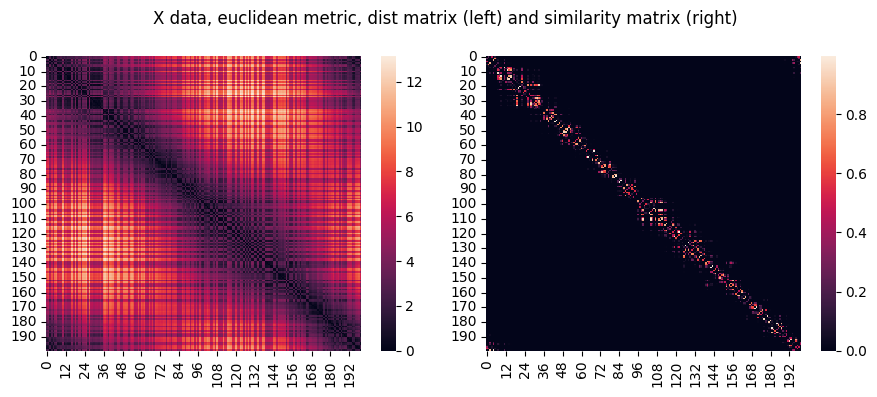

In [35]:
f, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw=dict(width_ratios=[1, 1]))
dist, sim = get_dst_sim(x_data, 'euclidean')
sns.heatmap(dist, ax=axs[0])
plt.suptitle('X data, euclidean metric, dist matrix (left) and similarity matrix (right)');
sns.heatmap(sim, ax=axs[1])
f.tight_layout()

### На данных X с использованием euclidean метрики:
+ Расстояние от 0 до 12
+ Заметно, что расстояние между подряд идущими наблюдениям минимально.
+ Similarity везде, кроме главное диагонали близко к 0.2 и ниже

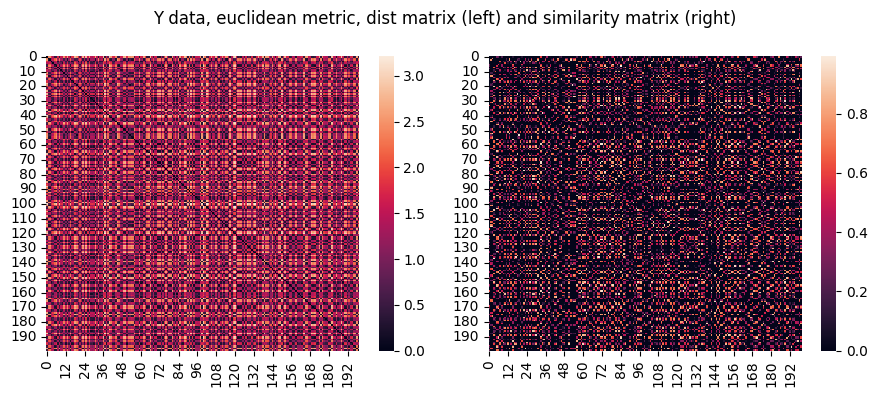

In [36]:
f, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw=dict(width_ratios=[1, 1]))
dist, sim = get_dst_sim(y_data, 'euclidean')
sns.heatmap(dist, ax=axs[0])
plt.suptitle('Y data, euclidean metric, dist matrix (left) and similarity matrix (right)');
sns.heatmap(sim, ax=axs[1])
f.tight_layout()

### На данных Y с использованием euclidean метрики:
+ Расстояние от 0 до 3
+ Так как в данных 3 кластера, но наблюдения идую не сортировно по кластрам, то явной зависимости не видно

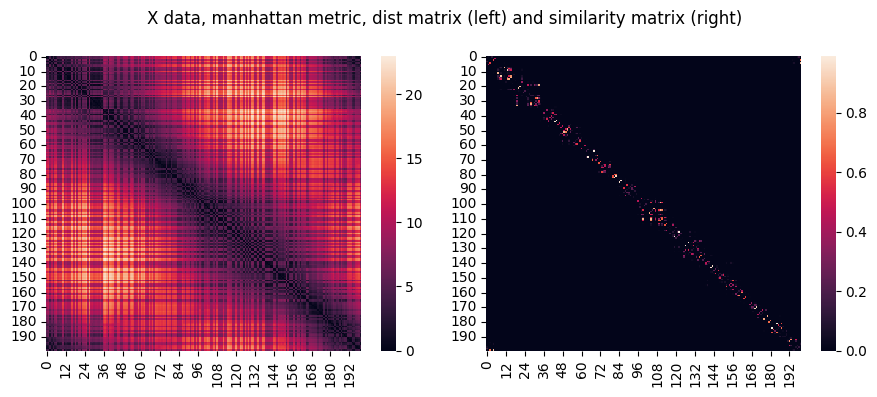

In [37]:
f, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw=dict(width_ratios=[1, 1]))
dist, sim = get_dst_sim(x_data, 'manhattan')
plt.suptitle('X data, manhattan metric, dist matrix (left) and similarity matrix (right)');
sns.heatmap(dist, ax=axs[0])
sns.heatmap(sim, ax=axs[1])
f.tight_layout()

### На данных X с использованием manhattan метрики:
+ Расстояние от 0 до 3
+ С manhattan метрикой визуализация очень похожа на euclidean, выводы можно сделать такие же 

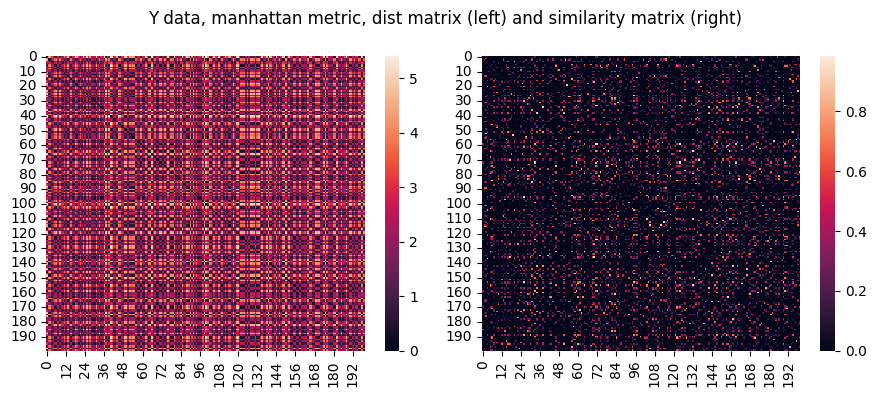

In [38]:
f, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw=dict(width_ratios=[1, 1]))
dist, sim = get_dst_sim(y_data, 'manhattan')
plt.suptitle('Y data, manhattan metric, dist matrix (left) and similarity matrix (right)');
sns.heatmap(dist, ax=axs[0])
sns.heatmap(sim, ax=axs[1])
f.tight_layout()

### На данных Y с использованием manhattan метрики:
+ Расстояние от 0 до 5
+ Так как в данных 3 кластера, но наблюдения идую не сортировно по кластрам, то явной зависимости не видно

In [39]:
def plot_graph(data, data_simmilarity, b1, b2, title=None):
    data_dim_2 = PCA(n_components=2).fit_transform(data)
    data_dim_2_pos = {i: xy for i, xy in enumerate(data_dim_2)}

    _, ax = plt.subplots(figsize=(10, 10))

    G = nx.from_numpy_array(data_simmilarity)

    nx.draw_networkx_nodes(G, data_dim_2_pos, node_size=50)

    edges1 = [(u, v) for (u, v, d) in G.edges(data=True) if       d['weight'] < b1]
    edges2 = [(u, v) for (u, v, d) in G.edges(data=True) if b1 <= d['weight'] < b2]
    edges3 = [(u, v) for (u, v, d) in G.edges(data=True) if b2 <= d['weight']     ]

    def make_proxy(clr, **kwargs):
        return Line2D([0, 1], [0, 1], color=clr, **kwargs)

    proxies = []
    labels = []
    for e, w, a, ec, label in (
        (edges1, 0.2, 0.2, 'g', f'simmilarity in [0.0, {b1})'),
        (edges2, 0.2, 0.4, 'b', f'simmilarity in [{b1}, {b2})'),
        (edges3, 0.8, 1.0, 'r', f'simmilarity in [{b2}, 1.0]')
    ):
        nx.draw_networkx_edges(G, data_dim_2_pos, edgelist=e, width=w, alpha=a, edge_color=ec)
        proxies.append(make_proxy(ec, lw=2))
        labels.append(label)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.legend(proxies, labels)
    plt.tight_layout()
    plt.show()

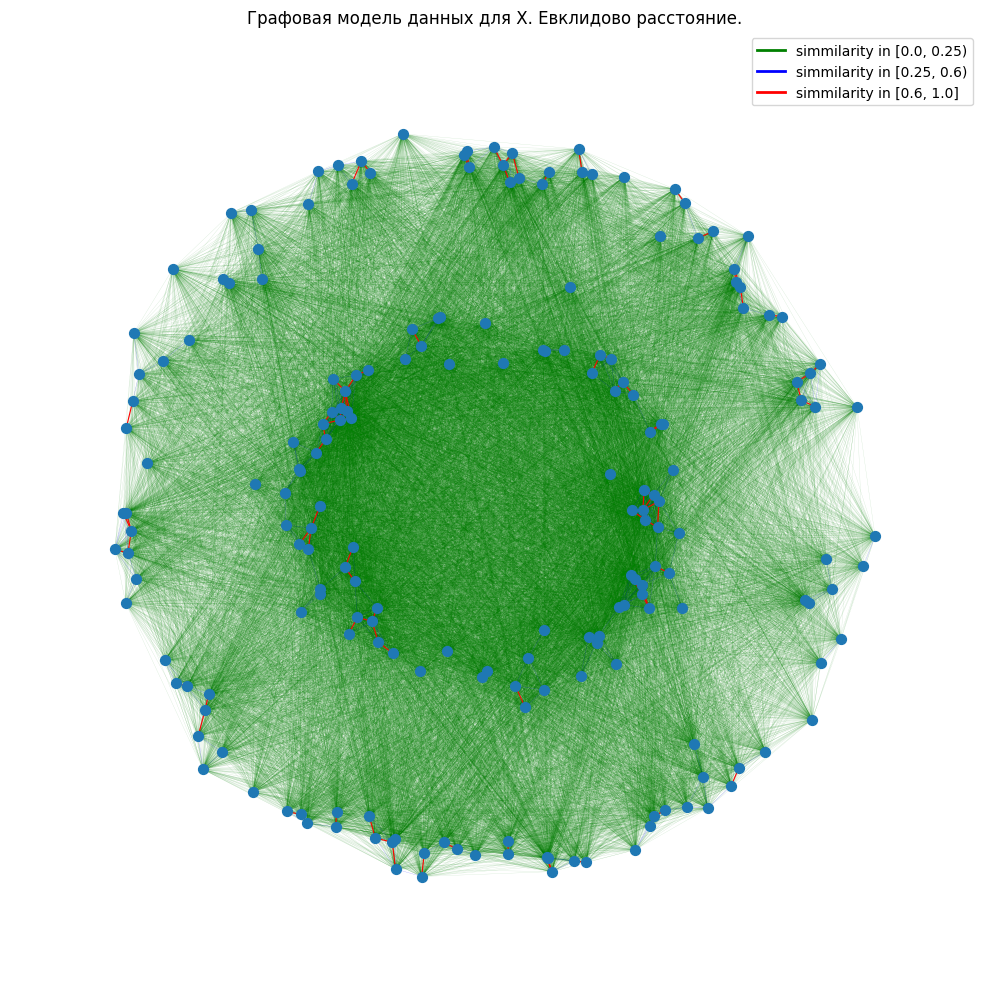

In [40]:
_, simmilarity = get_dst_sim(x_data, 'euclidean')
plot_graph(x_data, simmilarity, b1=0.25, b2=0.6, title='Графовая модель данных для X. Евклидово расстояние.')

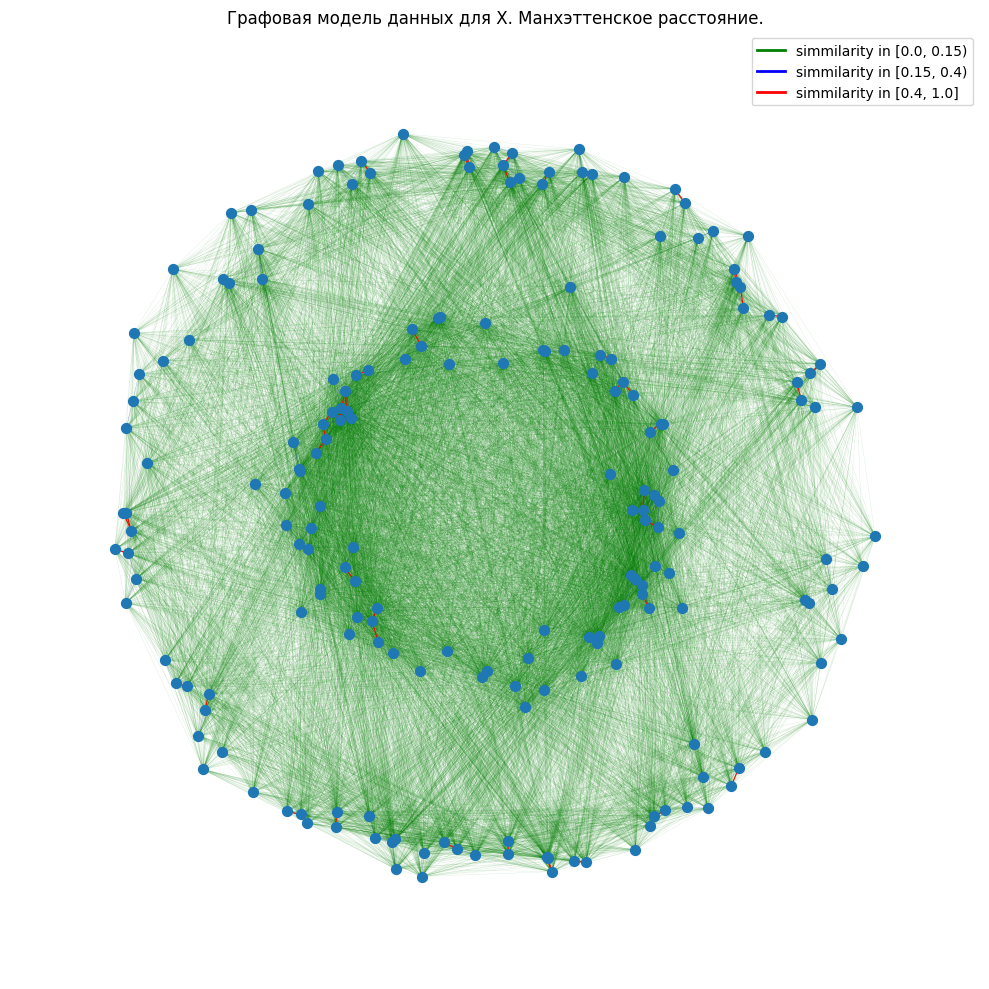

In [41]:
_, simmilarity = get_dst_sim(x_data, 'manhattan')
plot_graph(x_data, simmilarity, b1=0.15, b2=0.4, title='Графовая модель данных для X. Манхэттенское расстояние.')

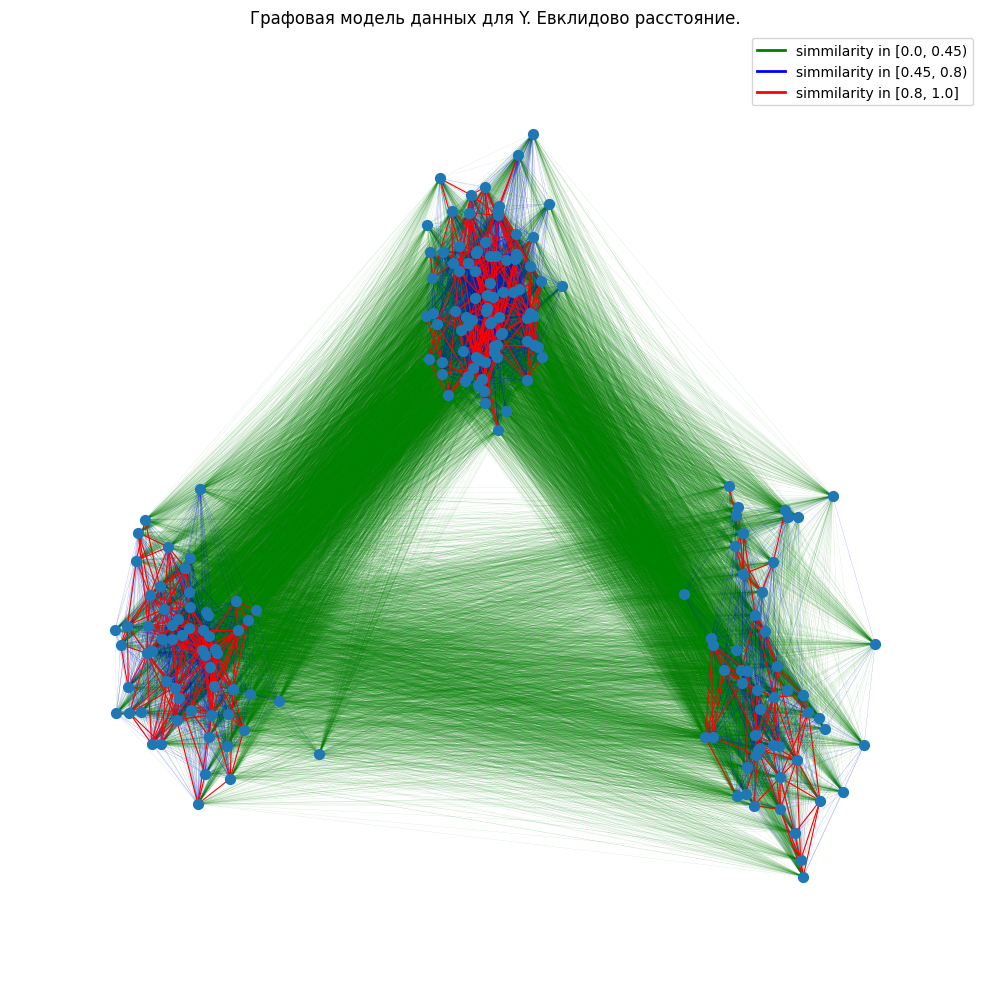

In [42]:
_, simmilarity = get_dst_sim(y_data, 'euclidean')
plot_graph(y_data, simmilarity, b1=0.45, b2=0.8, title='Графовая модель данных для Y. Евклидово расстояние.')

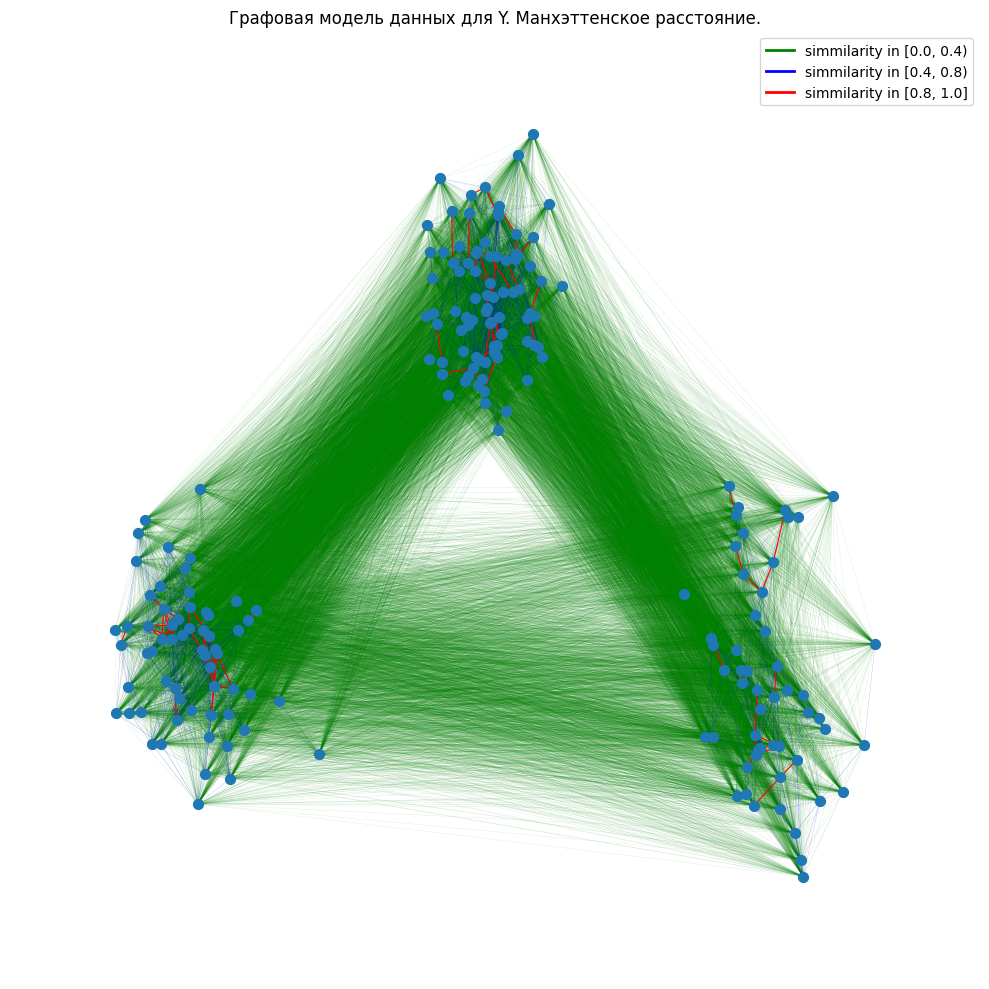

In [43]:
_, simmilarity = get_dst_sim(y_data, 'manhattan')
plot_graph(y_data, simmilarity, b1=0.4, b2=0.8, title='Графовая модель данных для Y. Манхэттенское расстояние.')

### Построили графы на основе simmilarity matrix и подобрали значения для ракраски ребер, показывающие значение схожести вершин. (зеленые - малая схожесть, синие - средняя, красные - сильная)

# Вспомогательный код

In [44]:
def calc_modularity(graph, partition):
    clusters = np.max(partition) + 1
    communities = []
    for k in range(clusters):
        communities.append(np.where(k == partition)[0])
    return nx.community.modularity(graph, communities)


def compare_ami(partitions):
    n = len(partitions)
    mat = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            mat[i, j] = adjusted_mutual_info_score(partitions[i], partitions[j])
    return mat


def compare_rand_index(partitions):
    n = len(partitions)
    mat = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            mat[i, j] = rand_score(partitions[i], partitions[j])
    return mat

 - Функция calc_modularity вычисляет модулярность графа на основе заданной разбиения.

 - Функция compare_rand_index сравнивает разбиения графа на основе коэффициента Rand.

In [45]:
def experiment(k, data, is_plot=True):
    distance, simmilarity = get_dst_sim(data, 'euclidean')
    graph = nx.from_numpy_array(simmilarity)

    algos = [
        (data,        AgglomerativeClustering(n_clusters=k, linkage='single', connectivity=simmilarity)),
        (data,        KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_SEED)),
        (data,        GaussianMixture(n_components=k, init_params='random', random_state=RANDOM_SEED)),
        (simmilarity, SpectralClustering(n_clusters=k, affinity='precomputed', random_state=RANDOM_SEED))
    ]

    ps = []
    ms = []
    ss = []
    dbs = []
    khs = []
    
    if is_plot:
        data_dim_2 = PCA(n_components=2).fit_transform(data)
        fig, axes = plt.subplots(nrows=4, figsize=(7, 10))

    for i, (dataset, algo) in enumerate(algos):
        ps.append(algo.fit_predict(dataset))
        ms.append(calc_modularity(graph, ps[-1]))
        try:
            ss.append(silhouette_score(distance, ps[-1], metric='precomputed'))
        except ValueError:
            ss.append(-1)
        dbs.append(davies_bouldin_score(distance, ps[-1]))
        khs.append(calinski_harabasz_score(data, ps[-1]))
        
        if is_plot:
            axes[i].scatter(data_dim_2[:, 0], data_dim_2[:, 1], c=ps[-1])
        

    labels = ['Single Linkage', 'KMeans', 'EM', 'Spectral']
    
    rand_index_mat = compare_rand_index(ps)
    rand_index_df = pd.DataFrame(rand_index_mat, index=labels, columns=labels)

    modularity_df = pd.DataFrame(ms, index=labels, columns=['modularity'])
    silhouette_df = pd.DataFrame(ss, index=labels, columns=['silhouette'])
    other_metrics_df = pd.merge(
        pd.DataFrame(khs, index=labels, columns=['calinski_harabasze']), 
        pd.DataFrame(dbs, index=labels, columns=['davies_bouldin']),
        left_index=True, right_index=True
    )    

    return modularity_df, rand_index_df, silhouette_df, other_metrics_df

In [46]:
def do_experiment(k, data_type):
    print(f'k = {k}, {data_type} data, евклидово расстояние')
    data = x_data if data_type == 'X' else y_data
    modularity_df, rand_index_df, silhouette_df, other_metrics_df = experiment(k, data)
    
    print('Попарные значения RAND index для разбиений')
    display(rand_index_df)
    print('Значения Modularity')
    display(modularity_df)
    print('Значения Silhouette score')
    display(silhouette_df)
    
    print('\nДоп: Другие метрики качества кластризации')
    display(other_metrics_df)

Код выше описывает логику эксперимента по кластеризации, проводимого на выбранных данных и с указанным параметром k - кол-во классов 

# Кластеризация для числа кластеров k=2

k = 2, X data, евклидово расстояние
Попарные значения RAND index для разбиений


Single Linkage    KMeans        EM  Spectral
Single Linkage        1.000000  0.497538  0.498744  1.000000
KMeans                0.497538  1.000000  0.633367  0.497538
EM                    0.498744  0.633367  1.000000  0.498744
Spectral              1.000000  0.497538  0.498744  1.000000

Значения Modularity


modularity
Single Linkage    0.487279
KMeans            0.495994
EM                0.466659
Spectral          0.487279

Значения Silhouette score


silhouette
Single Linkage    0.067588
KMeans            0.451041
EM                0.327888
Spectral          0.067588


Доп: Другие метрики качества кластризации


calinski_harabasze  davies_bouldin
Single Linkage            0.010987        2.910046
KMeans                  217.821556        0.903261
EM                      104.131082        1.422484
Spectral                  0.010987        2.910046

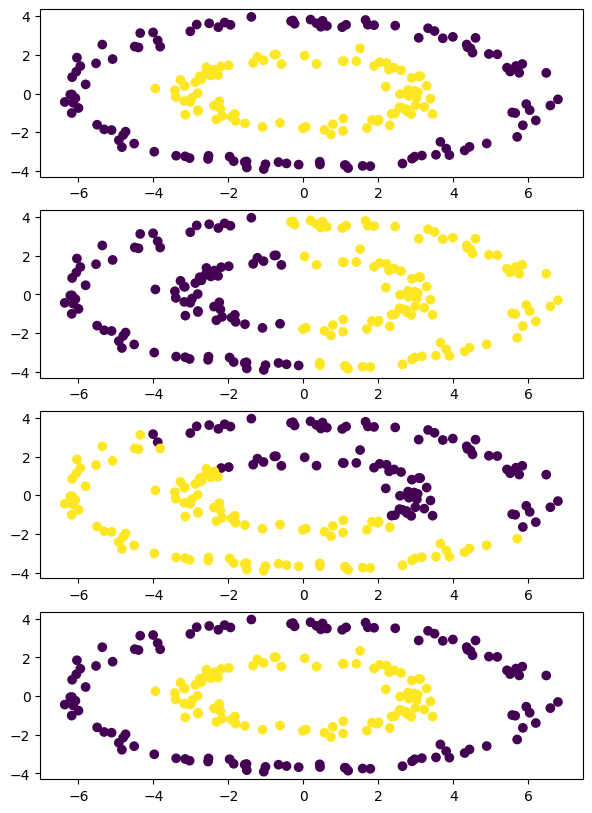

In [47]:
do_experiment(2, 'X')

### Выводы по Rand Index
+ Разбиение, полученное алгоритмом Single Linkage аналогично Spectral ~1 (т.е. их разбиения идентичны)
+ Разбиение, полученное алгоритмами KMeans, аналогично EM ~0.63
+ Все остальные пары в сравнении имеюит RI ~0.49

По rand index нельзя судить о самом качестве кластеризации, поэтому рассмотрим другие метрики качества

### Выводы по Modularity

+ Качество кластеризации можно оценить с помощью Modularity и Silhouette
+ Судя по Modularity, лучший алгоритм - KMeans (0.495994) и следом за ним Spectral и Single Linkage (0.487279), стоит заметить, что EM не сильно отстатет.
+ Судя по Silhouette, лучшие также - KMeans (0.451041) и следом за ним EM (0.327888), а вот Spectral и Single Linkage имеют значение гораздо хуже.

### Выводы по Индексу Калински–Харабаша и Индексу Дэвиса–Боулдина 

**Индекс Калински–Харабаша - компактность основана на расстоянии от точек кластера до их центроидов, а разделимость - на расстоянии от центроид кластеров до глобального центроида. Должен возрастать.**

**Индекс Дэвиса–Боулдина - компактность, основана на расстоянии от объектов кластера до их центроидов, а отделимость - как расстояние между центроидами. Должен минимизироваться для роста кластеризации.**

ps. Центроид кластера — это среднее значение объектов по каждой из переменных.

+ Судя по этим метрикам, лучшие также - KMeans (~217 и ~0.9) и EM (~104 и ~1.4).
+ А вот Spectral и Single Linkage в этот раз уже сильно хуже показывают.

## Важное замечание

+ По визуализации можно увидеть, что несмотря на все метрики, Single Linkage и Spactral лучше всего кластризует данные, но т.к. метрики считают расстояния от центров кластеров, а с этим данными такой подход не релевантен, так как один кластре находится внутри другого. /

k = 2, Y data, евклидово расстояние
Попарные значения RAND index для разбиений


Single Linkage    KMeans        EM  Spectral
Single Linkage        1.000000  1.000000  0.507337  1.000000
KMeans                1.000000  1.000000  0.507337  1.000000
EM                    0.507337  0.507337  1.000000  0.507337
Spectral              1.000000  1.000000  0.507337  1.000000

Значения Modularity


modularity
Single Linkage    0.415315
KMeans            0.415315
EM                0.304403
Spectral          0.415315

Значения Silhouette score


silhouette
Single Linkage    0.584502
KMeans            0.584502
EM                0.552660
Spectral          0.584502


Доп: Другие метрики качества кластризации


calinski_harabasze  davies_bouldin
Single Linkage          315.687095        0.532714
KMeans                  315.687095        0.532714
EM                      262.565203        0.587921
Spectral                315.687095        0.532714

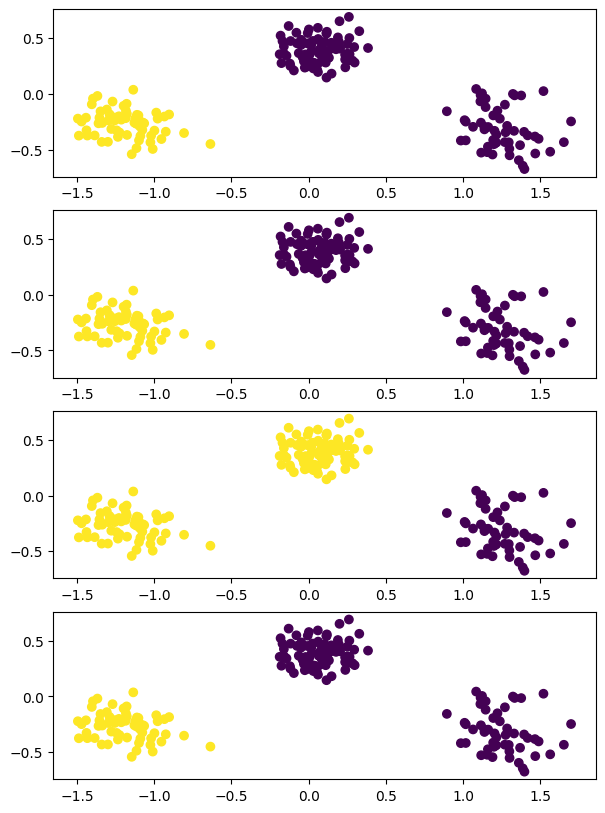

In [48]:
do_experiment(2, 'Y')

### Выводы по Rand Index
+ Разбиение, полученное алгоритмами KMeans, Single Linkage и Spectral аналогичны друг другу: RI = 1
+ Разбиение, полученное алгоритмами EM аналогично остальным на ~0.5 
+ По визуализации можно проанализировать, что заметно 3 кластера, но т.к. мы задаем кластеризацию на 2, то модели по разному объединяют кластеры между собой, поэтому те кто объединяют одинаковые кластеры, получают RI=1, а те кто не угадывают RI=0.5

По rand index нельзя судить о самом качестве кластеризации, поэтому рассмотрим другие метрики качества

### Выводы по Modularity

+ Качество кластеризации можно оценить с помощью Modularity и Silhouette
+ Судя по Modularity, лучший алгоритм - Single Linkage, Spectral и KMeans (0.415315)
+ Судя по Silhouette, лучшие также - Single Linkage, Spectral  и KMeans (0.584502) 
+ Стоит заметить, что относительно EM алгоритм не сильно хуже остальных.

### Выводы по Индексу Калински–Харабаша и Индексу Дэвиса–Боулдина 

+ Судя по этим метрикам, аналогичны метрикам выше, Single Linkage, Spectral и KMeansl лучше кластризуют, но разница не разительна.

# Кластеризация для числа кластеров k=3

k = 3, X data, евклидово расстояние
Попарные значения RAND index для разбиений


Single Linkage    KMeans        EM  Spectral
Single Linkage        1.000000  0.550754  0.510553  1.000000
KMeans                0.550754  1.000000  0.690151  0.550754
EM                    0.510553  0.690151  1.000000  0.510553
Spectral              1.000000  0.550754  0.510553  1.000000

Значения Modularity


modularity
Single Linkage    0.566911
KMeans            0.603283
EM                0.470009
Spectral          0.566911

Значения Silhouette score


silhouette
Single Linkage    0.115067
KMeans            0.386398
EM                0.429755
Spectral          0.115067


Доп: Другие метрики качества кластризации


calinski_harabasze  davies_bouldin
Single Linkage           28.910767        1.980411
KMeans                  177.315033        1.276324
EM                      196.201295        0.918624
Spectral                 28.910767        1.980411

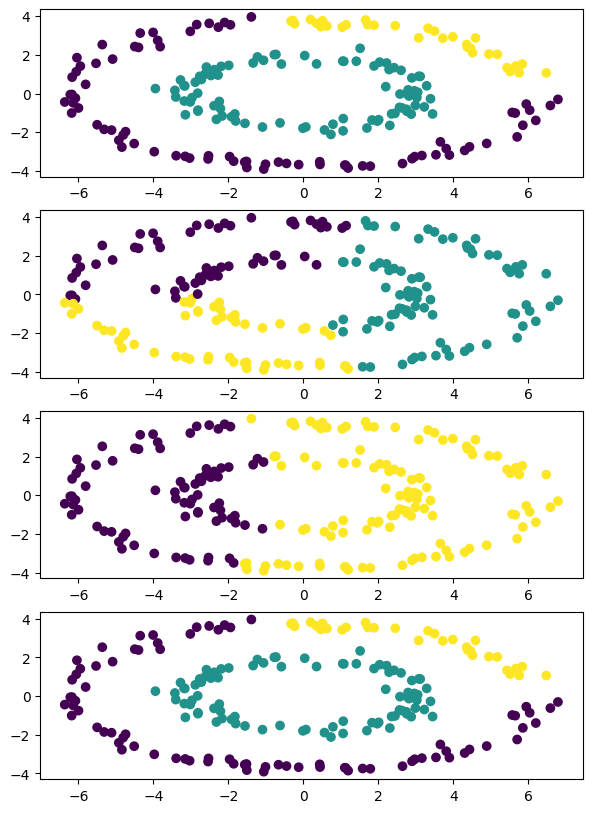

In [49]:
do_experiment(3, 'X')

### Выводы по Rand Index
+ Разбиение, полученное алгоритмом Single Linkage и Spectral аналогичны. RI = 1
+ Разбиение, полученное алгоритмами KMeans, аналогично EM ~0.69
+ Остальные пары аналогичны друг другу на RI = ~0.51 

По rand index нельзя судить о самом качестве кластеризации, поэтому рассмотрим другие метрики качества

### Выводы по Modularity

+ Качество кластеризации можно оценить с помощью Modularity и Silhouette
+ Судя по Modularity, лучший алгоритм - KMeans (0.603283) и следом за ним Spectral и Single Linkage (0.566911)
+ Судя по Silhouette, лучшим является EM алгоритм (0.429755) и следом за ним KMeans (0.386398). Spectral и Single Linkage досточно сильно хуже, сукдя по метрике. 

### Выводы по Индексу Калински–Харабаша и Индексу Дэвиса–Боулдина 

+ Судя по этим метрикам, лучший - EM (~196 и ~0.91).
+ Как и с KMeans не сильно проседяют по метрикам, а Spectral и Single Linkage сильно хуже.

## Важное замечание

+ Как и в примере с 2 кластерами, стоит заметить, что по визуализации видно, что Single Linkage иSpectral лучше всего кластризует данные, но метрики это не показывают (объясняли в пункте с k=2).

k = 3, Y data, евклидово расстояние
Попарные значения RAND index для разбиений


Single Linkage  KMeans   EM  Spectral
Single Linkage             1.0     1.0  1.0       1.0
KMeans                     1.0     1.0  1.0       1.0
EM                         1.0     1.0  1.0       1.0
Spectral                   1.0     1.0  1.0       1.0

Значения Modularity


modularity
Single Linkage    0.609184
KMeans            0.609184
EM                0.609184
Spectral          0.609184

Значения Silhouette score


silhouette
Single Linkage    0.706793
KMeans            0.706793
EM                0.706793
Spectral          0.706793


Доп: Другие метрики качества кластризации


calinski_harabasze  davies_bouldin
Single Linkage           981.47882         0.27035
KMeans                   981.47882         0.27035
EM                       981.47882         0.27035
Spectral                 981.47882         0.27035

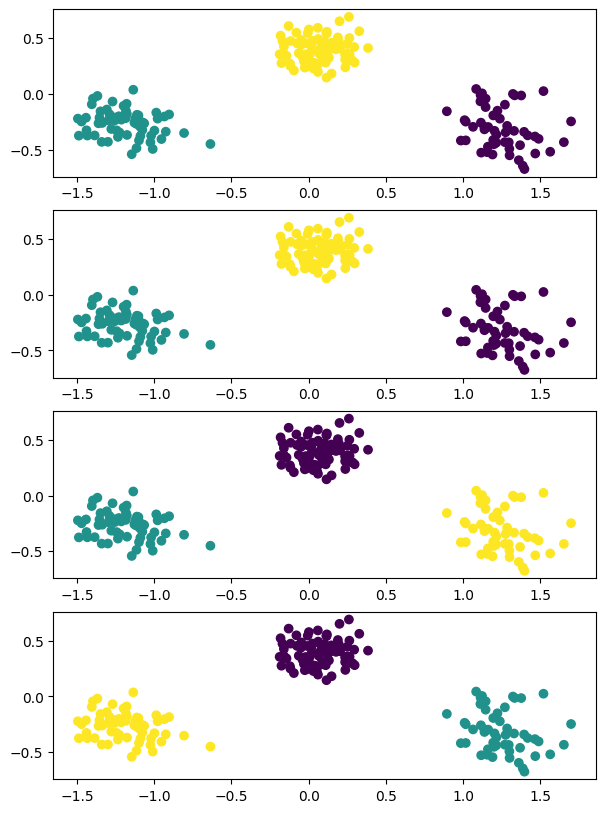

In [50]:
do_experiment(3, 'Y')

### Выводы по Rand Index
+ Разбиение всех алгоритмов идентичны, т.к по визуализации отлично видны три кластера и все алгоритмы идеально справляются с их нахождением.

### Выводы по остальным метрикам
+ Как было сказано выше, все алгоритмы, судя по визуализации, идеально справляются с нахождением всех трех кластеров, а значит и метрики идентичны.
+ Modularity = 0.609184
+ Silhouette = 0.706793
+ Calinski_harabasze = 981.47882
+ Davies_bouldin = 0.27035

# Общий случай

In [51]:
def silhouette_method(k_range, data_type):
    data = x_data if data_type == 'X' else y_data
    results = []
    for k in k_range:
        _, _, silhouette_df, _ = experiment(k, data, is_plot=False)
        results.append(silhouette_df.values.flatten())
    return np.array(results).T


def do_silhouette_method(k_range, data_type):
    fig1, ax = plt.subplots()
    fig2, axes = plt.subplots(nrows=4,  figsize=(7, 10))
    results = silhouette_method(k_range, data_type)
    ks = list(k_range)
    labels = ['Single Linkage', 'KMeans', 'EM', 'Spectral']
    
    best_score_indexes = np.argmax(results, axis=1)

    for i in range(len(results)):
        ax.plot(ks, results[i], label=labels[i])

        best_score = results[i][best_score_indexes[i]]
        ax.scatter(best_score_indexes[i] + ks[0], best_score)
    
    data = x_data if data_type == 'X' else y_data
    data_dim_2 = PCA(n_components=2).fit_transform(data)
    distance, simmilarity = get_dst_sim(data, 'euclidean')

    best_score_indexes += 2
    algos = [
        (data,        AgglomerativeClustering(n_clusters=best_score_indexes[0], linkage='single', connectivity=distance)),
        (data,        KMeans(n_clusters=best_score_indexes[1], n_init='auto')),
        (data,        GaussianMixture(n_components=best_score_indexes[2], init_params='random')),
        (simmilarity, SpectralClustering(n_clusters=best_score_indexes[3], affinity='precomputed'))
    ]

    for i, (dataset, algo) in enumerate(algos):
        p = algo.fit_predict(dataset)
        axes[i].scatter(data_dim_2[:, 0], data_dim_2[:, 1], c=p)
        axes[i].set_title(f'{labels[i]}, k = {best_score_indexes[i]}')

    
    ax.set_xticks(ks)
    ax.set_xticklabels(ks)
    ax.set_ylim(0, 1)
    ax.set_title('Значения среднего коэффициента силуэта при различных k')
    ax.legend()
    fig2.tight_layout()
    plt.show()

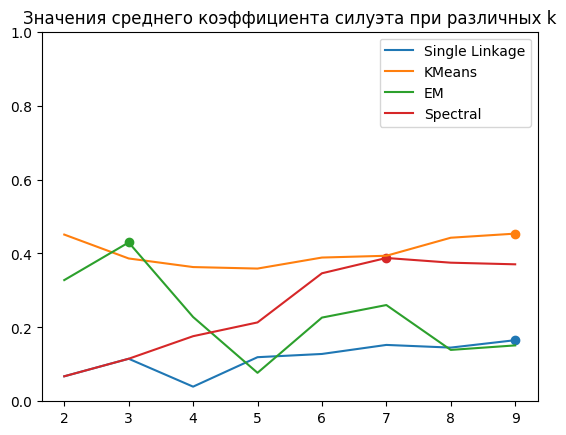

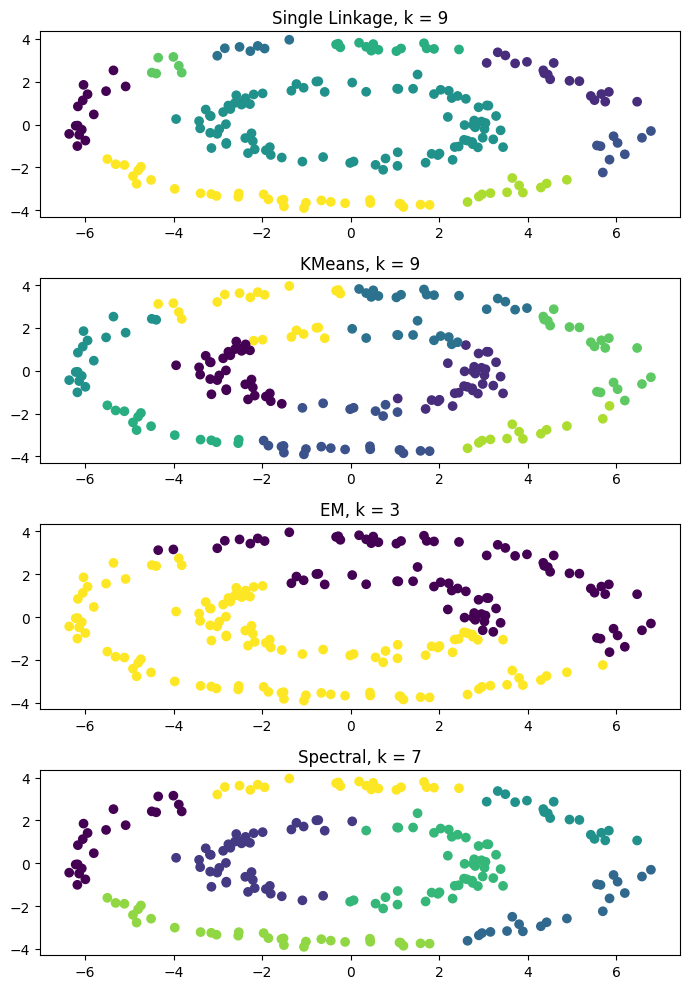

In [52]:
do_silhouette_method(range(2, 10), 'X')

### Для подбора лучшего кол-ва кластеров в каждом алгоритме использовался Silhouette score.
+ Т.к. мы подбираем кластеры по Silhouette, но он не так качественно, как хотелось бы, работает для этих данных, то и 2 кластера не являются лучшими ни у одной модели.

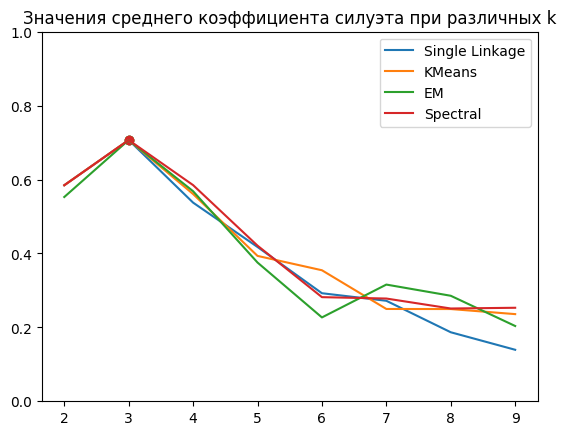

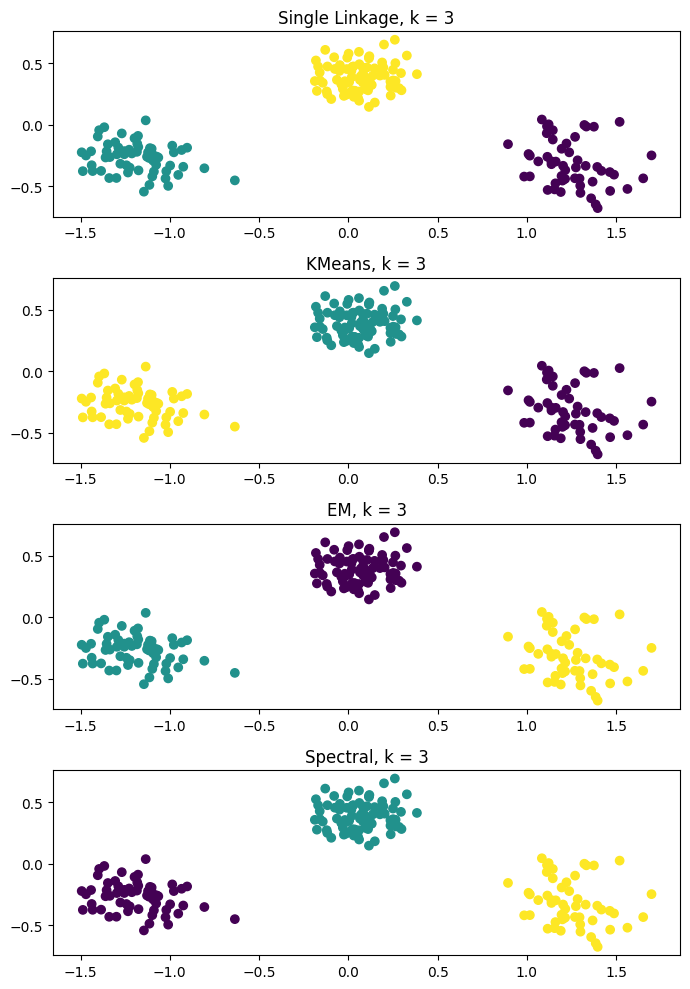

In [53]:
do_silhouette_method(range(2, 10), 'Y')

### Для подбора лучшего кол-ва кластеров в каждом алгоритме использовался Silhouette score.
+ Для всех моделей лучшее разбиение является 3 кластера, что по визуализации является правильным. 
+ Все алгоритмы отлично справляются с задачей выделения 3 кластеров.